# Importing dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import importlib
import utils
importlib.reload(utils)

In [ ]:
df = pd.read_csv('data.csv').drop(columns = 'ID', axis=1)
df = df.dropna(axis=0, how='any')
X = df.drop(columns = 'class', axis = 1 )
y = df['class']

# Explanatory variable

In [ ]:
int_columns, float_columns, object_columns, numerical_columns = utils.columns_df(X)

# Target variable

In [ ]:
y.value_counts()

In [ ]:
y = y.replace({'P': 1, 'H': 0})

Let's group each task as one sub X dataframe

In [ ]:
dataframes = utils.split_df(X, n = 25, n_col=18)
keys = list(dataframes.keys())

# PCA

We will collect Principal components for each task following the kaiser criteria

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
df_pca = {}
X_pca = pd.DataFrame()
for k in keys:
    scaler = StandardScaler()
    df_k = dataframes[k]
    df_k_scaled = scaler.fit_transform(df_k)
    pca = PCA(n_components=17)
    df_pca_k = pca.fit_transform(df_k_scaled)
    name_columns = ['task_'+str(k[2:]) + '_PC_'+str(x) for x in range(1,18)]
    df_pca_k = pd.DataFrame(df_pca_k, columns=name_columns)
    eigenvalues = pca.explained_variance_ # eigen values
    kaiser_criteria = eigenvalues > 1 # kaiser
    num_components = np.sum(kaiser_criteria)
    
    df_pca[k] = df_pca_k.iloc[:, :num_components]    
    X_pca = pd.concat([X_pca, df_pca[k]], axis = 1)

In [ ]:
X_pca.head()

# Train and test dataset split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y, test_size=0.2, random_state=123)
#print(X_train2.shape, y_train2.shape)
#print(X_test2.shape, y_test2.shape)

# Metric: recall for class 1 (no healthy)

In [ ]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score
scorer = make_scorer(recall_score, pos_label=1)

In [ ]:
# number of k folds
k_1 = 2
scores_k_1 = []
k_2 = 5
scores_k_2 = []
k_3 = 10
scores_k_3= []

name_classifiers=['RF', 'KNN', 'MLP', 'DT', 'NB', 'LR','SVM', 'Stacked']

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=123)

scores = cross_val_score(clf_rf, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_rf, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_rf, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=3)

scores = cross_val_score(clf_knn, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_knn, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_knn, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
scores = cross_val_score(clf_mlp, X, y, cv=k_1, scoring=scorer)

scores = cross_val_score(clf_mlp, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_mlp, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_mlp, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

## Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf_dtree = DecisionTreeClassifier()

scores = cross_val_score(clf_dtree, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_dtree, X, y, cv=k_1, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_dtree, X, y, cv=k_1, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

## NB

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()

scores = cross_val_score(clf_nb, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_nb, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_nb, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

## LR

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=1000)

scores = cross_val_score(clf_lr, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))

scores = cross_val_score(clf_lr, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))

scores = cross_val_score(clf_lr, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

## SVM

In [ ]:
from sklearn.svm import SVC
clf_svm = SVC(kernel='linear')
scores = cross_val_score(clf_svm, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))
scores = cross_val_score(clf_svm, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))
scores = cross_val_score(clf_svm, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

## Stacking model

In [ ]:
base_learners = [
    ('rf', clf_rf),
    ('knn', clf_knn),
    ('mlp', clf_mlp),
    ('nb', clf_nb),
    ('dt', clf_dtree),
    ('lr', clf_lr),
    ('svm', clf_svm)
]

meta_learners = LogisticRegression()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
stacking_classifier = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learners
)

stacking_classifier.fit(X_train, y_train)
y_pred = stacking_classifier.predict(X_test)

In [ ]:
scores = cross_val_score(stacking_classifier, X, y, cv=k_1, scoring=scorer)
scores_k_1.append(np.mean(scores))
scores = cross_val_score(stacking_classifier, X, y, cv=k_2, scoring=scorer)
scores_k_2.append(np.mean(scores))
scores = cross_val_score(stacking_classifier, X, y, cv=k_3, scoring=scorer)
scores_k_3.append(np.mean(scores))

print(np.mean(scores))

In [ ]:
results_df = pd.DataFrame()
results_df['learner'] = name_classifiers
results_df['k_2'] = scores_k_1
results_df['k_5'] = scores_k_2
results_df['k_10'] = scores_k_3

In [ ]:
results_df

In [ ]:
len(results_df)

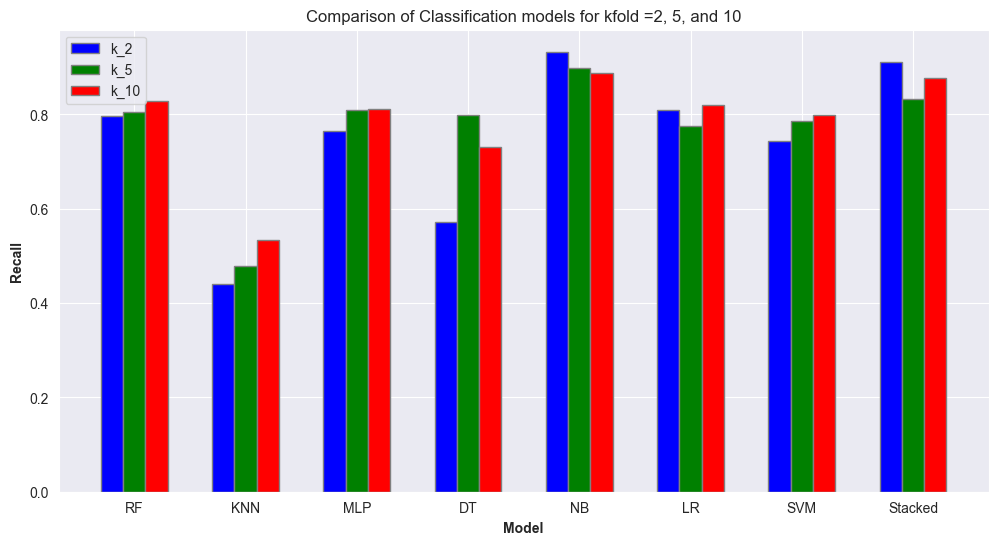

In [68]:
# Plotting the data
plt.figure(figsize=(12, 6))
bar_width = 0.2

# Set position of bar on X axis
r1 = range(len(results_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the plot
plt.bar(r1, results_df['k_2'], color='b', width=bar_width, edgecolor='grey', label='k_2')
plt.bar(r2, results_df['k_5'], color='g', width=bar_width, edgecolor='grey', label='k_5')
plt.bar(r3, results_df['k_10'], color='r', width=bar_width, edgecolor='grey', label='k_10')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Recall', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(results_df))], results_df['learner'])

# Create legend & Show graphic
plt.legend()
plt.title('Comparison of Classification models for kfold =2, 5, and 10')
plt.show()